# VEST VA 2017 State House

In [1]:
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt
import numpy as np
import os
pd.set_option('display.max_columns', None)

## Load VEST file

In [3]:
gdfv = gp.read_file('./raw_from_source/va_2017_statehouse/va_2017_statehouse.shp')
gdfv.head()

,COUNTYFP,LOCALITY,VTDST,PRECINCT,HOD_DIST,G17HODDEM,G17HODREP,G17HODIND,G17HODLIB,G17HODGRE,G17HODWRI,geometry
0,001,Accomack County,000101,Chincoteague,100,357,879,0,0,0,0,"POLYGON Z ((-75.42507 37.89957 0.00000, -75.42..."
1,001,Accomack County,000201,Atlantic,100,107,447,0,0,0,0,"POLYGON Z ((-75.59978 37.87664 0.00000, -75.59..."
2,001,Accomack County,000202,Greenbackville,100,202,493,0,0,0,7,"POLYGON Z ((-75.49919 37.93416 0.00000, -75.49..."
3,001,Accomack County,000301,New Church,100,362,418,0,0,0,0,"POLYGON Z ((-75.64987 37.92702 0.00000, -75.64..."
4,001,Accomack County,000401,Bloxom,100,70,263,0,0,0,0,"POLYGON Z ((-75.71556 37.87513 0.00000, -75.71..."


In [4]:
#To be used later to create county fips column in elections df
county_dict = pd.Series(gdfv['COUNTYFP'].values, index = gdfv['LOCALITY']).to_dict()

## Load election results

In [5]:
#Load in and then concatenate to have all results in one dataframe
elections_by_district = []
#i is district number for the 100 HOD districts in VA
for i in range(1,101):
    ref = './raw_from_source/VA-State-Sourcefiles/'
    file_name = ref + 'Virginia_Elections_Database__2017_House_of_Delegates_General_Election_District_'+ str(i) +'_including_precincts.csv'
    results = pd.read_csv(file_name)
    #print(i, ' added to list')
    #zfill dist # to match vest format
    results['HOD_DIST'] = str(i).zfill(3)
    
    #Create matching column format to VEST using fact that first row in each df is the candidates party 
    col_to_delete = []
    prefix = "G17HOD"
    party_to_abrv = {'Republican':'REP','Democratic':'DEM', 'Libertarian':'LIB', 'Green':'GRE', 'Independent':'IND'}
    for col in results.columns:
        #Account for all others column
        if col == 'All Others':
            col_to_delete.append(col)
            results['G17HODWRI'] = results[col]
            
        #Account for party columns
        maybe_party = results.loc[0,col]
        if maybe_party in party_to_abrv.keys():
            col_to_delete.append(col)
            #print(col, ' ---> ', prefix + party_to_abrv[maybe_party])
            results = results.fillna(value = 0)
            results[prefix + party_to_abrv[maybe_party]] = results[col]
            results[prefix + party_to_abrv[maybe_party]] = results[prefix + party_to_abrv[maybe_party]]

    results = results.drop(col_to_delete, axis = 1)
    results = results.iloc[1:]
    
    # For each district file loaded in, add to list to create the one df instead of 100 separate
    elections_by_district.append(results)
    
df = pd.concat(elections_by_district, axis = 0)
df = df.fillna(value = 0)

#Weird that Pct does not automatically load in as str, but nonetheless, must change
df['Pct'] = df['Pct'].astype(str)
#Change column name just for consistency with VEST
df['LOCALITY'] = df['County/City']
#Create County fip column using county names dict
df['COUNTYFP'] = df['LOCALITY'].map(county_dict)
#Drop columns just because not necessary for validation
df = df.drop(['County/City', 'Ward', 'Total Votes Cast'], axis = 1)
#Need to cut out totals column because otherwise column checks all doubled in df compared to vest
df = df[df['LOCALITY'] != 'TOTALS']
#Enables vote comparison having 0 instead of NA
df = df.fillna(value = 0)
#Change data type of votes
df['G17HODREP'] = df['G17HODREP'].map(lambda x: str(x).replace(',', '')).astype(str).astype(float).astype(int) 
df['G17HODDEM'] = df['G17HODDEM'].map(lambda x: str(x).replace(',', '')).astype(str).astype(float).astype(int) 
df['G17HODWRI'] = df['G17HODWRI'].map(lambda x: str(x).replace(',', '')).astype(str).astype(float).astype(int) 
df['G17HODIND'] = df['G17HODIND'].map(lambda x: str(x).replace(',', '')).astype(str).astype(float).astype(int) 
df['G17HODGRE'] = df['G17HODGRE'].map(lambda x: str(x).replace(',', '')).astype(str).astype(float).astype(int) 
df['G17HODLIB'] = df['G17HODLIB'].map(lambda x: str(x).replace(',', '')).astype(str).astype(float).astype(int) 

df.head()

,Pct,HOD_DIST,G17HODREP,G17HODDEM,G17HODWRI,G17HODIND,G17HODGRE,G17HODLIB,LOCALITY,COUNTYFP
1,101 - Elydale,001,251,68,0,0,0,0,Lee County,105
2,102 - Ewing,001,253,69,0,0,0,0,Lee County,105
3,103 - Rose Hill,001,495,131,1,0,0,0,Lee County,105
4,201 - Blackwater,001,84,39,0,0,0,0,Lee County,105
5,202 - Flatwoods,001,430,101,1,0,0,0,Lee County,105


## Check race totals and county-by-county totals

In [6]:
#Function to check column/race totals
def colum_total_check(column_list, elections_df, vest_df):
    for val in column_list:
        vote_dif = elections_df[val].sum()-vest_df[val].sum()
        if (vote_dif == 0):
            print(val+": EQUAL", ' - total: ', str(elections_df[val].sum()))
        else:
            print(val+": DIFFERENCE OF " + str(vote_dif)+ " VOTES", ' - rdh total: ', str(elections_df[val].sum()), ', vest total: ', str(vest_df[val].sum()))
            
#Function to check county totals
def county_total_check(column_list, elections_df, vest_df):
    print("Counties with differences printed below:")
    diff_counties=[]
    for i in column_list:
        diff = elections_df.groupby(["COUNTYFP"]).sum()[i]-vest_df.groupby(["COUNTYFP"]).sum()[i]
        for val in diff[diff != 0].index.values.tolist():
            if val not in diff_counties:
                diff_counties.append(val)
        if len(diff[diff != 0]!=0):
            print(i)
            print(diff[diff != 0].to_string(header=False))
    print("")
    print("All other races in all counties are equal")

In [7]:
column_list = ['G17HODDEM','G17HODREP', 'G17HODIND', 'G17HODLIB', 'G17HODGRE', 'G17HODWRI']

In [8]:
colum_total_check(column_list, df, gdfv)

G17HODDEM: EQUAL  - total:  1304242
G17HODREP: EQUAL  - total:  1076082
G17HODIND: EQUAL  - total:  26603
G17HODLIB: EQUAL  - total:  6295
G17HODGRE: EQUAL  - total:  6409
G17HODWRI: EQUAL  - total:  36856


In [9]:
county_total_check(column_list, df, gdfv)

Counties with differences printed below:

All other races in all counties are equal


## Reallocate Absentee Votes

In [10]:
#Create dfs that are groupbys based on needed categories for comparison - with and without absentee - to set up for reallocation fxn
df = df.reset_index()

df['countyfp_hd'] = df['COUNTYFP'] + '-' + df['HOD_DIST']

absentee_and_prov = df[(df['Pct'].map(lambda x: 'Absentee' in str(x))) | (df['Pct'].map(lambda x: 'Provisional' in str(x)))]

groupby_absentee_and_prov_tot = absentee_and_prov.groupby(['countyfp_hd']).sum()

groupby_county_df_tot = df.groupby(['countyfp_hd']).sum()
df_no_absent_or_provisional = df[(df['Pct'].map(lambda x: 'Absentee' not in str(x))) & (df['Pct'].map(lambda x: 'Provisional' not in str(x)))]
groupby_county_tot_no_absentee = df_no_absent_or_provisional.groupby('countyfp_hd').sum()

#Copy dfs to set up for reallocation to create new df
df_with_absentee_reallocated = df_no_absent_or_provisional.copy()
groupby_absentee_and_prov_tot.reset_index(inplace=True,drop=False)
groupby_county_tot_no_absentee.reset_index(inplace=True,drop=False)

to_dole_out_totals = groupby_absentee_and_prov_tot.copy()
precinct_specific_totals = groupby_county_tot_no_absentee.copy()

In [11]:
## PH CODE for vote allocation adapted by LF to be functions

#Create some new columns for each of these races to deal with the allocation
def rounding_columns_creation(column_list, elections_df):
    for race in column_list:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        elections_df.loc[:,add_var]=0.0
        elections_df.loc[:,rem_var]=0.0
        elections_df.loc[:,floor_var]=0.0

#Iterate over the rows
#Note this function iterates over the dataframe two times so the rounded vote totals match the totals to allocate
def iterate_df_to_add_rounding(column_list, df_no_absent_or_provisional, elections_df, precinct_specific_totals, to_dole_out_totals):
    for index, row in df_no_absent_or_provisional.iterrows():
        for race in column_list:
            add_var = race+"_add"
            rem_var = race+"_rem"
            floor_var = race+"_floor"
            #Grab the district
            county_id = row["countyfp_hd"]
            #Get the denominator for the allocation (the precinct vote totals)
            denom = precinct_specific_totals.loc[precinct_specific_totals["countyfp_hd"]==county_id][race]
            #Get one of the numerators, how many districtwide votes to allocate
            numer = to_dole_out_totals.loc[to_dole_out_totals["countyfp_hd"]==county_id][race]
            #Get the vote totals for this race in this precinct
            val = elections_df.at[index,race]
            #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
            if ((float(denom)==0)):
                vote_share = 0
            else:
                vote_share = (float(val)/float(denom))*float(numer)
            elections_df.at[index,add_var] = vote_share
            #Take the decimal remainder of the allocation
            elections_df.at[index,rem_var] = vote_share%1
            #Take the floor of the allocation
            elections_df.at[index,floor_var] = np.floor(vote_share)

    #After the first pass through, get the sums of the races by district to assist in the rounding            
    first_allocation = pd.DataFrame(elections_df.groupby(["countyfp_hd"]).sum())

    #Now we want to iterate district by district to work on rounding
    county_list = list(to_dole_out_totals["countyfp_hd"].unique()) 

    #Iterate over the county/district
    for county in county_list:
        for race in column_list:
            add_var = race+"_add"
            rem_var = race+"_rem"
            floor_var = race+"_floor"
            #County how many votes still need to be allocated (because we took the floor of all the initial allocations)
            to_go = int(np.round((int(to_dole_out_totals.loc[to_dole_out_totals["countyfp_hd"]==county][race])-first_allocation.loc[first_allocation.index==county,floor_var])))
            #Grab the n precincts with the highest remainders and round these up, where n is the # of votes that still need to be allocated
            for index in elections_df.loc[elections_df["countyfp_hd"]==county][rem_var].nlargest(to_go).index:
                elections_df.at[index,add_var] = np.ceil(elections_df.at[index,add_var])

    #Iterate over every race again
    for race in column_list:
        add_var = race+"_add"
        #Round every allocation down to not add fractional votes
        elections_df.loc[:,add_var]=np.floor(elections_df.loc[:,add_var])
        elections_df.loc[:,race]+=elections_df.loc[:,add_var]
        
def absentee_reallocation(column_list, elections_df, df_no_absent_or_provisional, precinct_specific_totals, to_dole_out_totals):
    rounding_columns_creation(column_list, elections_df)
    iterate_df_to_add_rounding(column_list, df_no_absent_or_provisional, elections_df, precinct_specific_totals, to_dole_out_totals)
    print("Absentee reallocation complete!")

In [12]:
#call absentee reallocation fxn
absentee_reallocation(column_list, df_with_absentee_reallocated, df_no_absent_or_provisional, precinct_specific_totals, to_dole_out_totals)

Absentee reallocation complete!


### re-check vote totals post reallocation

In [13]:
#Run function to check race tots
colum_total_check(column_list, df_with_absentee_reallocated, gdfv)

G17HODDEM: EQUAL  - total:  1304242.0
G17HODREP: EQUAL  - total:  1076082.0
G17HODIND: EQUAL  - total:  26603.0
G17HODLIB: EQUAL  - total:  6295.0
G17HODGRE: EQUAL  - total:  6409.0
G17HODWRI: EQUAL  - total:  36856.0


In [14]:
#Run function to check county tots
county_total_check(column_list, df_with_absentee_reallocated, gdfv)

Counties with differences printed below:

All other races in all counties are equal


In [15]:
len(set((gdfv['COUNTYFP']+gdfv['VTDST'].str.slice(start = 3)+gdfv['HOD_DIST']))-set(df_with_absentee_reallocated.COUNTYFP + df_with_absentee_reallocated.Pct.str.slice(stop = 3) + df_with_absentee_reallocated['HOD_DIST']))

375

In [16]:
len(set(df_with_absentee_reallocated.COUNTYFP + df_with_absentee_reallocated.Pct.str.slice(stop = 3) + df_with_absentee_reallocated['HOD_DIST'])-set((gdfv['COUNTYFP']+gdfv['VTDST'].str.slice(start = 3)+gdfv['HOD_DIST'])))

374

Next, create unique id in `df_with_absentee_reallocated` and `gdfv` and attempt merge

## Create unique id

In [17]:
#Notice part of VTDST code is in Pct identifier. Cut out and apply
df_with_absentee_reallocated['vtdst'] = df_with_absentee_reallocated.Pct.str.slice(stop = 3)
# Function to fix formatting for VTDST
def vtdst_changer(vtdst):
    if (vtdst[1:3] == ' -'):
        two_lead_zero = '00' + vtdst[:1]
        return two_lead_zero
    elif (vtdst[1:3] == '- '):
        two_lead_zero = '00' + vtdst[:1]
        return two_lead_zero
    elif (vtdst[-1:] == ' '):
        one_lead_zero = '0' + vtdst[:2]
        return one_lead_zero
    elif (vtdst[-1:] == '-'):
        one_lead_zero = '0' + vtdst[:2]
        return one_lead_zero
    else:
        return vtdst
    

In [18]:
df_with_absentee_reallocated['vtdst'] = df_with_absentee_reallocated['vtdst'].apply(vtdst_changer)
df_with_absentee_reallocated[df_with_absentee_reallocated['vtdst'].str.slice(start = -1) == '-'] #check that above worked

,index,Pct,HOD_DIST,G17HODREP,G17HODDEM,G17HODWRI,G17HODIND,G17HODGRE,G17HODLIB,LOCALITY,COUNTYFP,countyfp_hd,G17HODDEM_add,G17HODDEM_rem,G17HODDEM_floor,G17HODREP_add,G17HODREP_rem,G17HODREP_floor,G17HODIND_add,G17HODIND_rem,G17HODIND_floor,G17HODLIB_add,G17HODLIB_rem,G17HODLIB_floor,G17HODGRE_add,G17HODGRE_rem,G17HODGRE_floor,G17HODWRI_add,G17HODWRI_rem,G17HODWRI_floor,vtdst


In [19]:
#Assign unique id to df using tools
df_with_absentee_reallocated['unique_id'] = df_with_absentee_reallocated['COUNTYFP'] + df_with_absentee_reallocated['vtdst']
#Assign matching unique id to gdfv
gdfv['unique_id'] = gdfv['COUNTYFP'] + gdfv['VTDST'].str.slice(start = 3)
gdfv['unique_id'].nunique()
#Check where double values exist and that they overlap between df and vest file
df_id_count = df_with_absentee_reallocated['unique_id'].value_counts()
df_double_list = df_id_count[df_id_count > 1].index
gdfv_id_count = gdfv.unique_id.value_counts()
gdfv_double_list = gdfv_id_count[gdfv_id_count > 1].index
print(set(df_double_list) - set(gdfv_double_list))
print(set(gdfv_double_list) - set(df_double_list))

{'770018'}
set()


See in above, for this unique id, only appears in VEST file for the Pct labeled "18 - Old To Be Removed Virginia Heights-Norwich"... Why to be removed then?

### USE HOD_DIST to account for the rest of the unique ids that were double in the initial column

In [20]:
print('# unique values for gdfv unique id colummn with house district ', (gdfv['unique_id'] + gdfv['HOD_DIST']).nunique())
print('# unique values for df unique id colummn with house district in df ',(df_with_absentee_reallocated['unique_id'] + df_with_absentee_reallocated['HOD_DIST']).nunique())
#Use hod dist to assign new unique id column to df and vest file 
df_with_absentee_reallocated['old_unique_id'] = df_with_absentee_reallocated['unique_id']
df_with_absentee_reallocated['unique_id'] = df_with_absentee_reallocated['old_unique_id'] + '-' + df_with_absentee_reallocated['HOD_DIST']

gdfv['old_unique_id'] = gdfv['unique_id']
gdfv['unique_id'] = gdfv['old_unique_id'] + '-' + gdfv['HOD_DIST']
print('new unique id in vest file not in df: ', set(gdfv['unique_id']) - set(df_with_absentee_reallocated['unique_id']))
print('new unique id in df not in vest file: ', set(df_with_absentee_reallocated['unique_id']) - set(gdfv['unique_id']))

# unique values for gdfv unique id colummn with house district  2585
# unique values for df unique id colummn with house district in df  2584
new unique id in vest file not in df:  {'770021-011', '059700-037'}
new unique id in df not in vest file:  {'770018-017'}


In [21]:
gdfv[gdfv['unique_id'].isin(set(gdfv['unique_id']) - set(df_with_absentee_reallocated['unique_id']))]

,COUNTYFP,LOCALITY,VTDST,PRECINCT,HOD_DIST,G17HODDEM,G17HODREP,G17HODIND,G17HODLIB,G17HODGRE,G17HODWRI,geometry,unique_id,old_unique_id
560,059,Fairfax County,000700,Fairfax Court,037,0,0,0,0,0,0,"POLYGON Z ((-77.31648 38.84615 0.00000, -77.31...",059700-037,059700
2181,770,Roanoke City,000021,Eureka Park,011,1265,0,0,0,0,9,"POLYGON Z ((-79.99974 37.29491 0.00000, -79.99...",770021-011,770021


In [22]:
df_with_absentee_reallocated[df_with_absentee_reallocated['unique_id'].isin(set(df_with_absentee_reallocated['unique_id']) - set(gdfv['unique_id']))]

,index,Pct,HOD_DIST,G17HODREP,G17HODDEM,G17HODWRI,G17HODIND,G17HODGRE,G17HODLIB,LOCALITY,COUNTYFP,countyfp_hd,G17HODDEM_add,G17HODDEM_rem,G17HODDEM_floor,G17HODREP_add,G17HODREP_rem,G17HODREP_floor,G17HODIND_add,G17HODIND_rem,G17HODIND_floor,G17HODLIB_add,G17HODLIB_rem,G17HODLIB_floor,G17HODGRE_add,G17HODGRE_rem,G17HODGRE_floor,G17HODWRI_add,G17HODWRI_rem,G17HODWRI_floor,vtdst,unique_id,old_unique_id
662,35,18 - Summit Hills,017,0.0,0.0,0.0,0.0,0.0,0.0,Roanoke City,770,770-017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,018,770018-017,770018


### Join attempt 1 - election results to vest to check precinct totals

In [23]:
join_1_df_vest = pd.merge(df_with_absentee_reallocated, gdfv, on = 'unique_id', how = 'outer', indicator = True)
print(join_1_df_vest["_merge"].value_counts())

both          2584
right_only       2
left_only        1
Name: _merge, dtype: int64


## Preliminary precinct level election result comparison

In [24]:
def validater_row (df, column_List):
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for j in range(0,len(df.index)):
        same = True
        for i in column_List:
            left_Data = i + "_x"
            right_Data = i + "_y"
            diff = abs(df.iloc[j][left_Data]-df.iloc[j][right_Data])
            if(diff >0):
                if(diff>1): #7/12/21 LF mod to be >1 instead of >0 to print fewer results
                    print(i, "{:.>72}".format(df.iloc[j]["unique_id"]), "(V)","{:.>5}".format(int(df.iloc[j][left_Data]))," (S){:.>5}".format(int(df.iloc[j][right_Data])),"(D):{:>5}".format(int(df.iloc[j][right_Data])-int(df.iloc[j][left_Data])))           
                #print(df.iloc[j]['countypct'])
                
                diff_values.append(abs(diff))
                same = False
                if(np.isnan(diff)):
                    print("NaN value at diff is: ", df.iloc[j]["unique_id"])
                    print(df.iloc[j][left_Data])
                    print(df.iloc[j][right_Data])
                if (diff>max_diff):
                    max_diff = diff
                    #print("New max diff is: ", str(max_diff))
                    #print(df.iloc[j]['cty_pct'])
        if(same != True):
            different_rows +=1
            diff_list.append(df.iloc[j]["unique_id"])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    diff_list.sort()

In [25]:
validater_row(join_1_df_vest[join_1_df_vest['_merge'] == 'both'].sort_values("unique_id"),column_list)

G17HODDEM ..............................................................770018-011 (V) ..888  (S).1041 (D):  153
G17HODWRI ..............................................................770018-011 (V) ...30  (S)...21 (D):   -9
G17HODDEM ..............................................................770019-011 (V) ..514  (S)..888 (D):  374
G17HODWRI ..............................................................770019-011 (V) ....5  (S)...30 (D):   25
G17HODDEM ..............................................................770020-011 (V) .1264  (S)..514 (D): -750
G17HODWRI ..............................................................770020-011 (V) ....9  (S)....5 (D):   -4

There are  2584  total rows
829  of these rows have election result differences
1755  of these rows are the same

The max difference between any one shared column in a row is:  750.0
The average difference is:  2.3851851851851853
There are  4 precinct results with a difference greater than 10


In [26]:
#Notice that mismatches are in same county and district, and votes seem to be rearranged but some same values
df_with_absentee_reallocated[df_with_absentee_reallocated['unique_id'] == '770020-011']

,index,Pct,HOD_DIST,G17HODREP,G17HODDEM,G17HODWRI,G17HODIND,G17HODGRE,G17HODLIB,LOCALITY,COUNTYFP,countyfp_hd,G17HODDEM_add,G17HODDEM_rem,G17HODDEM_floor,G17HODREP_add,G17HODREP_rem,G17HODREP_floor,G17HODIND_add,G17HODIND_rem,G17HODIND_floor,G17HODLIB_add,G17HODLIB_rem,G17HODLIB_floor,G17HODGRE_add,G17HODGRE_rem,G17HODGRE_floor,G17HODWRI_add,G17HODWRI_rem,G17HODWRI_floor,vtdst,unique_id,old_unique_id
446,20,20 - Eureka Park,011,0.0,1264.0,9.0,0.0,0.0,0.0,Roanoke City,770,770-011,64.0,0.147391,64.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.460554,0.0,020,770020-011,770020


In [27]:
gdfv[gdfv['unique_id'] == '770021-011']

,COUNTYFP,LOCALITY,VTDST,PRECINCT,HOD_DIST,G17HODDEM,G17HODREP,G17HODIND,G17HODLIB,G17HODGRE,G17HODWRI,geometry,unique_id,old_unique_id
2181,770,Roanoke City,000021,Eureka Park,011,1265,0,0,0,0,9,"POLYGON Z ((-79.99974 37.29491 0.00000, -79.99...",770021-011,770021


In [28]:
df_with_absentee_reallocated[df_with_absentee_reallocated['unique_id'] == '770018-011']

,index,Pct,HOD_DIST,G17HODREP,G17HODDEM,G17HODWRI,G17HODIND,G17HODGRE,G17HODLIB,LOCALITY,COUNTYFP,countyfp_hd,G17HODDEM_add,G17HODDEM_rem,G17HODDEM_floor,G17HODREP_add,G17HODREP_rem,G17HODREP_floor,G17HODIND_add,G17HODIND_rem,G17HODIND_floor,G17HODLIB_add,G17HODLIB_rem,G17HODLIB_floor,G17HODGRE_add,G17HODGRE_rem,G17HODGRE_floor,G17HODWRI_add,G17HODWRI_rem,G17HODWRI_floor,vtdst,unique_id,old_unique_id
443,17,18 - Old To Be Removed Virginia Heights-Norwich,011,0.0,1041.0,21.0,0.0,0.0,0.0,Roanoke City,770,770-011,53.0,0.814685,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.151386,1.0,018,770018-011,770018
444,18,18 - Summit Hills,011,0.0,888.0,30.0,0.0,0.0,0.0,Roanoke City,770,770-011,45.0,0.063542,45.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.611940,1.0,018,770018-011,770018


In [29]:
df_with_absentee_reallocated[df_with_absentee_reallocated['Pct'] == '18 - Old To Be Removed Virginia Heights-Norwich']

,index,Pct,HOD_DIST,G17HODREP,G17HODDEM,G17HODWRI,G17HODIND,G17HODGRE,G17HODLIB,LOCALITY,COUNTYFP,countyfp_hd,G17HODDEM_add,G17HODDEM_rem,G17HODDEM_floor,G17HODREP_add,G17HODREP_rem,G17HODREP_floor,G17HODIND_add,G17HODIND_rem,G17HODIND_floor,G17HODLIB_add,G17HODLIB_rem,G17HODLIB_floor,G17HODGRE_add,G17HODGRE_rem,G17HODGRE_floor,G17HODWRI_add,G17HODWRI_rem,G17HODWRI_floor,vtdst,unique_id,old_unique_id
443,17,18 - Old To Be Removed Virginia Heights-Norwich,011,0.0,1041.0,21.0,0.0,0.0,0.0,Roanoke City,770,770-011,53.0,0.814685,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.151386,1.0,018,770018-011,770018


In [30]:
gdfv[gdfv['unique_id'] == '770018-011']

,COUNTYFP,LOCALITY,VTDST,PRECINCT,HOD_DIST,G17HODDEM,G17HODREP,G17HODIND,G17HODLIB,G17HODGRE,G17HODWRI,geometry,unique_id,old_unique_id
2532,770,Roanoke City,000018,Virginia Heights-Norwich,011,1041,0,0,0,0,21,"POLYGON Z ((-79.99789 37.26592 0.00000, -79.99...",770018-011,770018


In [31]:
gdfv[gdfv['unique_id'] == '770019-011']

,COUNTYFP,LOCALITY,VTDST,PRECINCT,HOD_DIST,G17HODDEM,G17HODREP,G17HODIND,G17HODLIB,G17HODGRE,G17HODWRI,geometry,unique_id,old_unique_id
2179,770,Roanoke City,000019,Summit Hills,011,888,0,0,0,0,30,"POLYGON Z ((-80.00955 37.27925 0.00000, -80.01...",770019-011,770019


In [32]:
df_with_absentee_reallocated[df_with_absentee_reallocated['unique_id'] == '770019-011']

,index,Pct,HOD_DIST,G17HODREP,G17HODDEM,G17HODWRI,G17HODIND,G17HODGRE,G17HODLIB,LOCALITY,COUNTYFP,countyfp_hd,G17HODDEM_add,G17HODDEM_rem,G17HODDEM_floor,G17HODREP_add,G17HODREP_rem,G17HODREP_floor,G17HODIND_add,G17HODIND_rem,G17HODIND_floor,G17HODLIB_add,G17HODLIB_rem,G17HODLIB_floor,G17HODGRE_add,G17HODGRE_rem,G17HODGRE_floor,G17HODWRI_add,G17HODWRI_rem,G17HODWRI_floor,vtdst,unique_id,old_unique_id
445,19,19 - Forest Park,011,0.0,514.0,5.0,0.0,0.0,0.0,Roanoke City,770,770-011,26.0,0.086606,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.287846,0.0,019,770019-011,770019


In [33]:
gdfv[gdfv['unique_id'] == '770020-011']

,COUNTYFP,LOCALITY,VTDST,PRECINCT,HOD_DIST,G17HODDEM,G17HODREP,G17HODIND,G17HODLIB,G17HODGRE,G17HODWRI,geometry,unique_id,old_unique_id
2180,770,Roanoke City,000020,Forest Park,011,514,0,0,0,0,5,"POLYGON Z ((-79.97599 37.29078 0.00000, -79.97...",770020-011,770020


**Precinct id Modifications observed above to create match**
election df '770020-011' = gdfv '770021-011'

election df '770018-011' = gdfv '770018-011'

election df '770018-011' #2 = gdfv '770019-011'

election df '770019-011' #2 = gdfv '770020-011'

In [34]:
df_with_absentee_reallocated['old_unique_id_1'] = df_with_absentee_reallocated['unique_id']
df_with_absentee_reallocated.loc[df_with_absentee_reallocated['old_unique_id_1']=='770020-011', 'unique_id'] = '770021-011'
df_with_absentee_reallocated.loc[df_with_absentee_reallocated['old_unique_id_1']=='770018-011', 'unique_id'] = '770019-011'
df_with_absentee_reallocated.loc[df_with_absentee_reallocated['Pct']=='18 - Old To Be Removed Virginia Heights-Norwich', 'unique_id'] = '770018-011'
df_with_absentee_reallocated.loc[df_with_absentee_reallocated['old_unique_id_1']=='770019-011', 'unique_id'] = '770020-011'

In [35]:
join_2_df_vest = pd.merge(df_with_absentee_reallocated, gdfv, on = 'unique_id', how = 'outer', indicator = True)
print(join_2_df_vest["_merge"].value_counts())

both          2584
left_only        1
right_only       1
Name: _merge, dtype: int64


In [36]:
join_2_df_vest[join_2_df_vest["_merge"]!="both"]

,index,Pct,HOD_DIST_x,G17HODREP_x,G17HODDEM_x,G17HODWRI_x,G17HODIND_x,G17HODGRE_x,G17HODLIB_x,LOCALITY_x,COUNTYFP_x,countyfp_hd,G17HODDEM_add,G17HODDEM_rem,G17HODDEM_floor,G17HODREP_add,G17HODREP_rem,G17HODREP_floor,G17HODIND_add,G17HODIND_rem,G17HODIND_floor,G17HODLIB_add,G17HODLIB_rem,G17HODLIB_floor,G17HODGRE_add,G17HODGRE_rem,G17HODGRE_floor,G17HODWRI_add,G17HODWRI_rem,G17HODWRI_floor,vtdst,unique_id,old_unique_id_x,old_unique_id_1,COUNTYFP_y,LOCALITY_y,VTDST,PRECINCT,HOD_DIST_y,G17HODDEM_y,G17HODREP_y,G17HODIND_y,G17HODLIB_y,G17HODGRE_y,G17HODWRI_y,geometry,old_unique_id_y,_merge
556,35.0,18 - Summit Hills,017,0.0,0.0,0.0,0.0,0.0,0.0,Roanoke City,770,770-017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,018,770018-017,770018,770018-017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,left_only
2585,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,059700-037,NaN,NaN,059,Fairfax County,000700,Fairfax Court,037,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON Z ((-77.31648 38.84615 0.00000, -77.31...",059700,right_only


See that remaining unmatched ids are zero vote precincts so can be ignored for election result comparison

In [37]:
#Re-run election result verification/comparison
validater_row(join_2_df_vest[join_2_df_vest['_merge'] == 'both'].sort_values("unique_id"),column_list)


There are  2584  total rows
827  of these rows have election result differences
1757  of these rows are the same

The max difference between any one shared column in a row is:  1.0
The average difference is:  1.0
There are  0 precinct results with a difference greater than 10


Satisfied with results since all are within +/- vote, means likely descrepencies only due to rounding

## Precinct Shapefile with HOD splits

<AxesSubplot:>

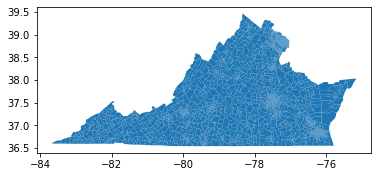

In [38]:
#Precinct boundary shapefile load in
county_fips = []
for directory in os.listdir('./raw_from_source/census_shps_by_county_all_unzip/'):
    if not directory[0] == '.':
        county_fips.append(directory[-5:])
        
proj = gdfv.crs   

county_vtds = []
for i in county_fips: #i dont have fips_codes file
    ref = './raw_from_source/census_shps_by_county_all_unzip/partnership_shapefiles_19v2_'
    vtd_ref = ref + i + '/PVS_19_v2_vtd_' + i + '.shp' 
    vtd_shp = gp.read_file(vtd_ref)
    county_vtds.append(vtd_shp)

shp_vtd = gp.GeoDataFrame(pd.concat(county_vtds, axis = 0) , crs = proj)

#HOD (sldl) boundary shapefile load in
county_sldl = []
for i in county_fips: #i dont have fips_codes file
    ref = './raw_from_source/census_shps_by_county_all_unzip/partnership_shapefiles_19v2_'
    sldl_ref = ref + i + '/PVS_19_v2_sldl_' + i + '.shp' 
    sldl_shp = gp.read_file(sldl_ref)
    county_sldl.append(sldl_shp)

shp_sldl = gp.GeoDataFrame(pd.concat(county_sldl, axis = 0) , crs = proj) 

#Overlay so we can split precincts by house districts
overlay = gp.overlay(shp_sldl, shp_vtd, how='intersection', make_valid=True, keep_geom_type=True)

overlay.plot()

In [44]:
overlay.geometry.nunique()

2823

In [45]:
gdfv.shape

(2585, 14)

In [46]:
overlay['unique_id'] = overlay['COUNTYFP_1'] + overlay['VTDST'].str.slice(start = 3) + '-' + overlay['SLDLST']

print('preliminary id in overlay not in vest: ', len((set(overlay['unique_id']) - set(gdfv['unique_id']))), 'overlay length:', overlay.shape[0])
print('preliminary id in vest not in overlay: ', len((set(gdfv['unique_id']) - set(overlay['unique_id']))), 'vest length', gdfv.shape[0])

preliminary id in overlay not in vest:  262 overlay length: 2823
preliminary id in vest not in overlay:  25 vest length 2585


In [47]:
join_overlay = pd.merge(gdfv, overlay, on = 'unique_id', how = 'outer', indicator = True)
print(join_overlay["_merge"].value_counts())

both          2560
right_only     263
left_only       25
Name: _merge, dtype: int64


In [48]:
left_only = join_overlay[join_overlay["_merge"]=="left_only"]
right_only = join_overlay[join_overlay["_merge"]=="right_only"]
left_only.to_csv("./gdfv_only_hod.csv")
right_only.to_csv("./overlay_only_hod.csv")

Hand matched in Excel using the csvs and precinct names to determine what needs to be merged versus split.

In [49]:
overlay_to_gdf_dict = {'121032-012':'121403-012',
'121032-012':'121203-012',
'121032-007':'121203-012',
'095042-093':'095104-093',
'095041-093':'095104-093',
'520041-005':'520004-005',
'520042-005':'520004-005',
'WALLACE PART 1 Voting District':'191702-004',
'WALLACE PART 2 Voting District':'191702-004',
'077011-005':'077401-005',
'077012-005':'077401-005',
#'OAKLAND Voting District'->'OAKLAND D','OAKLAND A' - not sure where to split
'685031-013':'685003-013',
'685032-013':'685003-013'}

In [50]:
#Apply dictionary to improve match rate
overlay['old_unique_id_w_cd'] = overlay['unique_id']
overlay.loc[overlay['old_unique_id_w_cd'].isin(overlay_to_gdf_dict.keys()), 'unique_id'] = overlay['old_unique_id_w_cd'].map(overlay_to_gdf_dict)
overlay.loc[overlay['NAMELSAD_2'].isin(overlay_to_gdf_dict.keys()), 'unique_id'] = overlay['NAMELSAD_2'].map(overlay_to_gdf_dict)
overlay = overlay.dissolve(by = 'unique_id', as_index = False)

## Join shapefile and election results

In [51]:
shp_df_merge = pd.merge(overlay, df_with_absentee_reallocated, on = 'unique_id', how = 'outer', suffixes = ['_x', '_y'], indicator=True)
shp_df_gdf = gp.GeoDataFrame(shp_df_merge, geometry = 'geometry')

#shp_df_gdf = shp_df_gdf.drop(['geometry_x', 'geometry_y'], axis = 1)

print(shp_df_gdf["_merge"].value_counts())

both          2566
left_only      249
right_only      19
Name: _merge, dtype: int64


In [52]:
overlay.shape

(2815, 44)

In [57]:
gdfv.shape

(2585, 14)

# Validation

## Shapefile

In [53]:
shp_gdfv_merge = pd.merge(shp_df_gdf, gdfv, on = 'unique_id', how = 'outer', suffixes = ['_x', '_y'])
shp_gdfv_merge = shp_gdfv_merge.reset_index()

both = shp_gdfv_merge[shp_gdfv_merge["_merge"]=="both"]
both.reset_index(drop=True,inplace=True)
source_geoms = gp.GeoDataFrame(both,geometry="geometry_x",crs=gdfv.crs)
vest_geoms = gp.GeoDataFrame(both,geometry="geometry_y",crs=gdfv.crs)
source_geoms = source_geoms.to_crs(3857)
vest_geoms = vest_geoms.to_crs(3857)
source_geoms["geometry_x"]=source_geoms.buffer(0)
vest_geoms["geometry_y"]=vest_geoms.buffer(0)
vals = source_geoms.geom_almost_equals(vest_geoms,decimal=0)
print(vals.value_counts())

False    2475
True       91
dtype: int64


1) For SOURCE: 003201-025, VEST: 003201-025 difference in area is 1.6356971556357536
2) For SOURCE: 003504-057, VEST: 003504-057 difference in area is 2.05940518861457
3) For SOURCE: 003604-025, VEST: 003604-025 difference in area is 2.571411925989262
4) For SOURCE: 019301-022, VEST: 019301-022 difference in area is 6.398193672651951
5) For SOURCE: 041213-070, VEST: 041213-070 difference in area is 1.1029929116712385
6) For SOURCE: 041304-066, VEST: 041304-066 difference in area is 7.916646768539404
7) For SOURCE: 041309-065, VEST: 041309-065 difference in area is 11.693771424346881
8) For SOURCE: 041402-027, VEST: 041402-027 difference in area is 2.248559309256872
9) For SOURCE: 057301-098, VEST: 057301-098 difference in area is 2.4720747911344634
10) For SOURCE: 057401-098, VEST: 057401-098 difference in area is 2.472074791134462
11) For SOURCE: 075202-065, VEST: 075202-065 difference in area is 1.0661417587320714
12) For SOURCE: 075401-056, VEST: 075401-056 difference in area is 2.6

/Users/lilyfalk/anaconda3/envs/pdv_env/lib/python3.9/site-packages/geopandas/plotting.py:384: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


22) For SOURCE: 147101-060, VEST: 147101-060 difference in area is 2.4946745290011005
23) For SOURCE: 147201-060, VEST: 147201-060 difference in area is 2.936365936002648
24) For SOURCE: 147301-060, VEST: 147301-060 difference in area is 2.93229544033087
25) For SOURCE: 147502-060, VEST: 147502-060 difference in area is 2.293644305239482
26) For SOURCE: 147601-060, VEST: 147601-060 difference in area is 1.1636920314767547
27) For SOURCE: 161103-008, VEST: 161103-008 difference in area is 1.1428572469198468
28) For SOURCE: 161405-017, VEST: 161405-017 difference in area is 1.0463387266166553
29) For SOURCE: 185101-003, VEST: 185101-003 difference in area is 3.1086260332856956
30) For SOURCE: 185103-003, VEST: 185103-003 difference in area is 10.75498554203434
31) For SOURCE: 185303-003, VEST: 185303-003 difference in area is 6.241248369995428
32) For SOURCE: 185401-003, VEST: 185401-003 difference in area is 5.17843722911882
33) For SOURCE: 550006-076, VEST: 550006-076 difference in are

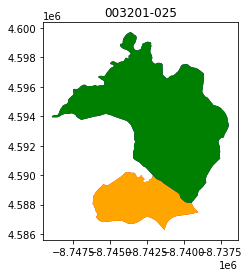

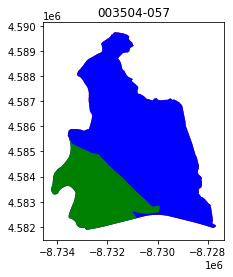

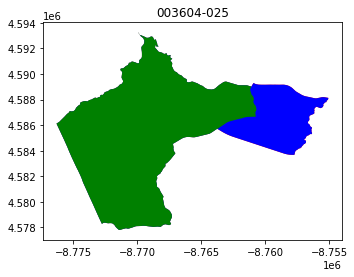

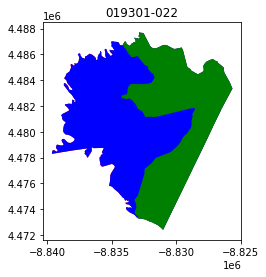

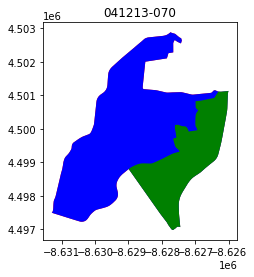

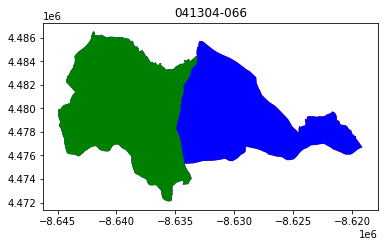

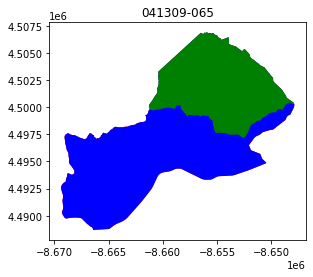

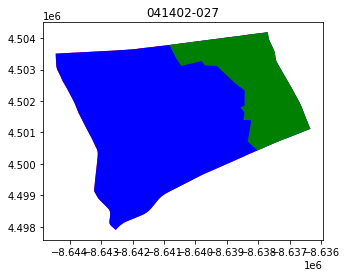

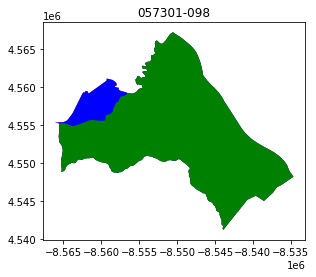

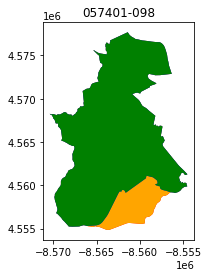

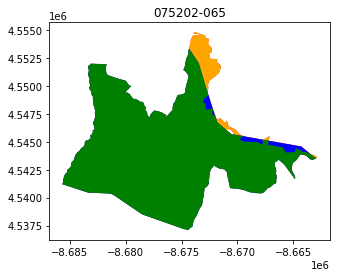

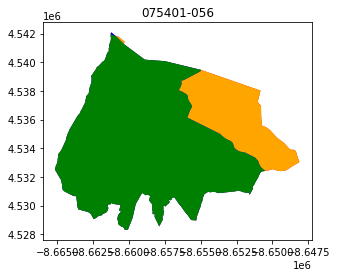

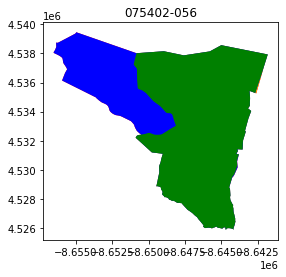

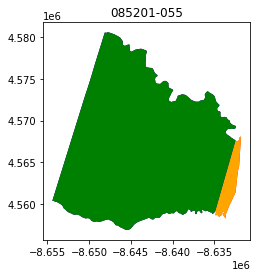

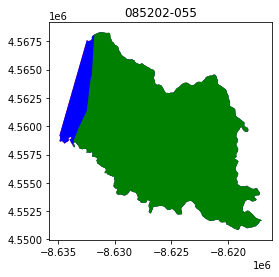

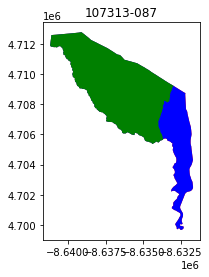

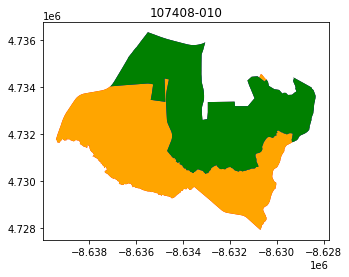

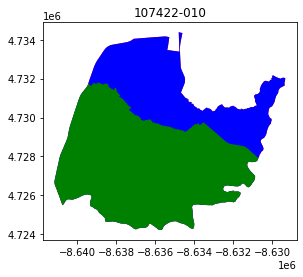

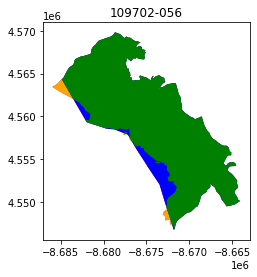

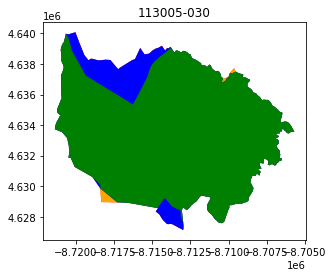

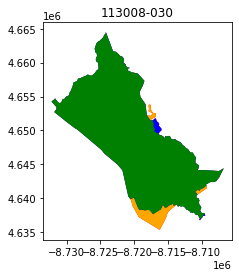

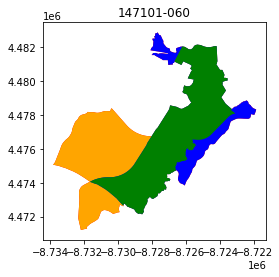

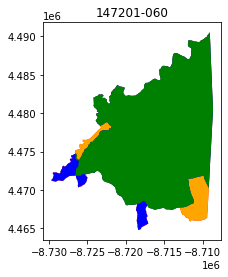

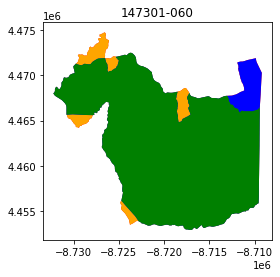

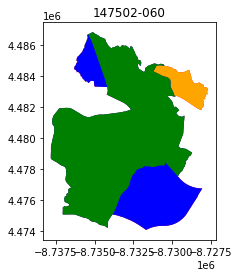

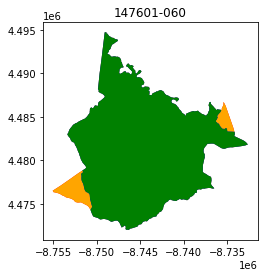

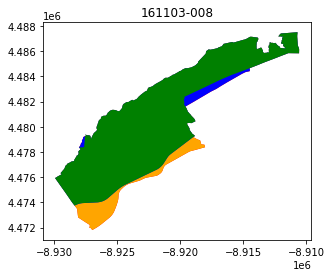

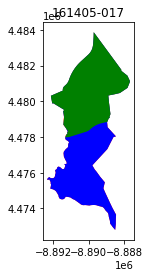

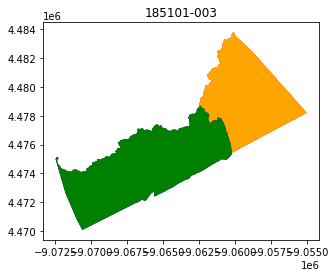

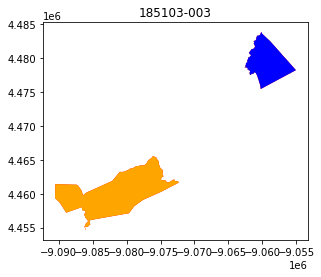

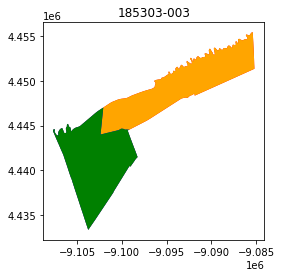

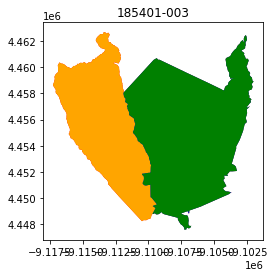

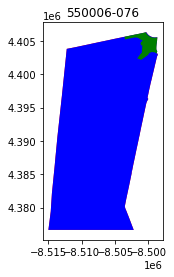

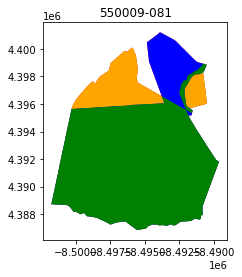

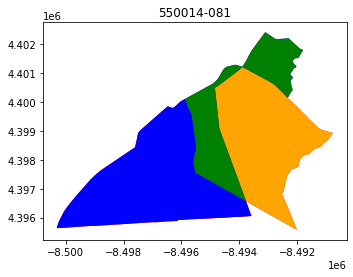

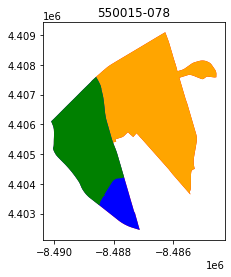

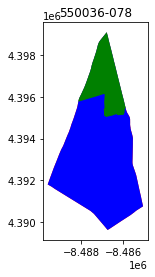

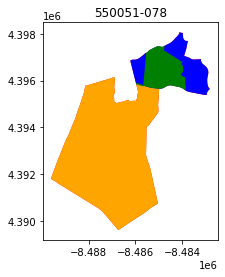

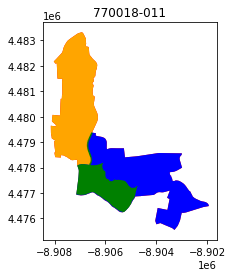

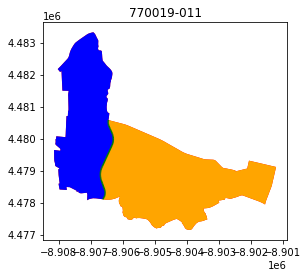

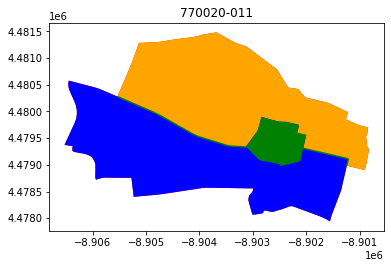

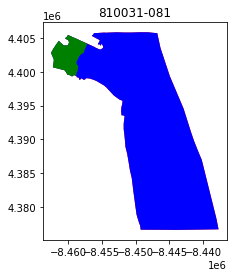

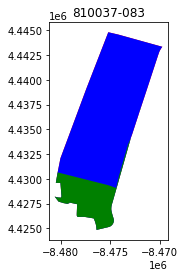

In [54]:
count = 0
area_list = []
big_diff = pd.DataFrame(columns=["area"])
for i in range(0,len(source_geoms)):
    diff = source_geoms.iloc[[i]].symmetric_difference(vest_geoms.iloc[[i]])
    intersection = source_geoms.iloc[[i]].intersection(vest_geoms.iloc[[i]])
    area = float(diff.area/10e6)
    area_list.append(area)
    #print("Area is " + str(area))

    if (area > 1):
        count += 1
        name = source_geoms.at[i,"unique_id"]
        big_diff.loc[name]=area
        print(str(count)+") For SOURCE: " + name + ', VEST: '+ vest_geoms.at[i,"unique_id"]+ " difference in area is " + str(area))
        if (intersection.iloc[0].is_empty):
            base = diff.plot(color="red")
            source_geoms.iloc[[i]].plot(color="orange",ax=base)
            vest_geoms.iloc[[i]].plot(color="blue",ax=base)
            base.set_title(name)
        else:
            base = diff.plot(color="red")
            source_geoms.iloc[[i]].plot(color="orange",ax=base)
            vest_geoms.iloc[[i]].plot(color="blue",ax=base)
            intersection.plot(color="green",ax=base)
            base.set_title(name)

In [55]:
df = pd.DataFrame(area_list)
print(df.shape)

print(str(len(df[df[0]==0]))+" precincts w/ a difference of 0 km^2")
print(str(len(df[(df[0]<.1) & (df[0]>0)]))+ " precincts w/ a difference between 0 and .1 km^2")
print(str(len(df[(df[0]<.5) & (df[0]>=.1)]))+ " precincts w/ a difference between .1 and .5 km^2")
print(str(len(df[(df[0]<1) & (df[0]>=.5)]))+ " precincts w/ a difference between .5 and 1 km^2")
print(str(len(df[(df[0]<2) & (df[0]>=1)]))+ " precincts w/ a difference between 1 and 2 km^2")
print(str(len(df[(df[0]<5) & (df[0]>=2)]))+ " precincts w/ a difference between 2 and 5 km^2")
print(str(len(df[(df[0]>=5)]))+ " precincts w/ a difference greater than 5 km^2")

(2566, 1)
1754 precincts w/ a difference of 0 km^2
684 precincts w/ a difference between 0 and .1 km^2
64 precincts w/ a difference between .1 and .5 km^2
20 precincts w/ a difference between .5 and 1 km^2
17 precincts w/ a difference between 1 and 2 km^2
17 precincts w/ a difference between 2 and 5 km^2
9 precincts w/ a difference greater than 5 km^2


## Election Results

In [56]:
validater_row(shp_gdfv_merge,column_list)


There are  2834  total rows
827  of these rows have election result differences
2007  of these rows are the same

The max difference between any one shared column in a row is:  1.0
The average difference is:  1.0
There are  0 precinct results with a difference greater than 10
